In [1]:
# 필요한 model을 import한다

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [2]:
# 본 모델의 학습과 성능평가를 위해 STL10 Dataset을 사용할 예정이다

# STL Dataset을 다운로드 받을 Directory를 지정한다
path2data = './data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
5000
8000


In [3]:
# DataLoader에 사용될 Pre-Processor를 정의한다
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(64)
])

train_ds.transform = transformation
val_ds.transform = transformation

# Train dataset, Validation dataset의 Dataloader 생성
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

In [4]:
from torch.nn.modules.batchnorm import BatchNorm2d
# DenseNet은 3개의 BottleNeck과 2개의 Transition으로 구성되어 있다
# 각 구성요소를 정의해 보자

# BottleNeck 구현
class BottleNeck(nn.Module):
  def __init__(self, in_channels, growth_rate):
    super().__init__()
    inner_channels = 4 * growth_rate

    self.residual = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels, inner_channels,1,stride=1, padding=0, bias=False),
        nn.BatchNorm2d(inner_channels),
        nn.ReLU(),
        nn.Conv2d(inner_channels, growth_rate,3,stride=1, padding=1, bias=False)
    )

    self.shortcut = nn.Sequential()

# BottleNeck Block에서 최종 출력될 때에는 (input_channel + growth_rate) 만큼의 channel수가 되어서 나온다
  def forward(self, x):
    return torch.cat([self.shortcut(x), self.residual(x)], 1)

# Feature map과 Channel수를 반으로 감소시키는
# Dense Block사이에 존재하는 Transition Block을 설계한다
class Transition(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.down_sample = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )
  
  def forward(self, x):
    return self.down_sample(x)

In [7]:
# 전체적인 DenseNet구조를 정의하자
# nblocks : [6,4,4,6]과 같은 list가 들어올 것이다
# 이는 각 DenseBlock내에 몇 개의 BottleNeck이 사용될 것인지를 정하는 것이다
# growth_rate : input_channel에 비해 총 얼마만큼의 채널이 증가된 채로 BottleNeck을 통과할 것인가
# reduction : 각 Transition계층에서 얼마만큼의 비율로 채널을 감소시킬 것인지 설정하는 파라미터
class DenseNet(nn.Module):
  def __init__(self, nblocks, growth_rate=12, reduction=0.5, num_classes=10, init_weights=True ):
    super().__init__()
    self.growth_rate = growth_rate
    inner_channels = 2*growth_rate

    self.conv1 = nn.Sequential(
        nn.Conv2d(3, inner_channels, 7, stride=2, padding=3),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

    self.features = nn.Sequential()

    # DenseNet에서 마지막 Dense Block 뒤에는 transition이 붙지 않는다
    # 그래서 len(blocks)-1개 만큼만 iteration해주는 것이다
    for i in range(len(nblocks)-1):
      self.features.add_module("dense_block_{}".format(i), self._make_dense_block(nblocks[i],inner_channels))
      inner_channels += growth_rate * nblocks[i] # 하나의 dense block통과할 때마다 channel이 growth_rate만큼 증가하므로
      out_channels = int(reduction * inner_channels)
      self.features.add_module("transition_layer_{}".format(i), Transition(inner_channels, out_channels))
      inner_channels = out_channels

    self.features.add_module("dense_block{}".format(len(nblocks)-1), self._make_dense_block(nblocks[len(nblocks)-1], inner_channels))
    inner_channels += growth_rate * nblocks[len(nblocks)-1]
    self.features.add_module("bn",nn.BatchNorm2d(inner_channels))
    self.features.add_module("relu", nn.ReLU())

    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.linear = nn.Linear(inner_channels, num_classes)
    
    if init_weights:
      self._initialize_weights()
    
  def forward(self,x):
    x = self.conv1(x)
    x = self.features(x)
    x = self.avg_pool(x)
    x = x.view(x.size(0),-1)
    x = self.linear(x)
    return x

  def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)  

  def _make_dense_block(self, nblock, inner_channels):
    dense_block = nn.Sequential()
    for i in range(nblock):
      dense_block.add_module("bottle_neck_layer_{}".format(i), BottleNeck(inner_channels, self.growth_rate))
      inner_channels += self.growth_rate
    return dense_block

def DenseNet_121():
  return DenseNet([6,12,24,6])

In [9]:
# 모델이 잘 구축되었는지 확인하기 위해 임의의 입력을 넣어보자
x = torch.randn(3,3,64,64)
model = DenseNet_121()
output = model(x)
print(output.size())

torch.Size([3, 10])


In [10]:
# 모델의 전체 구조를 확인하기 위해 summary를 출력하자
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]           3,552
         MaxPool2d-2           [-1, 24, 16, 16]               0
       BatchNorm2d-3           [-1, 24, 16, 16]              48
              ReLU-4           [-1, 24, 16, 16]               0
            Conv2d-5           [-1, 48, 16, 16]           1,152
       BatchNorm2d-6           [-1, 48, 16, 16]              96
              ReLU-7           [-1, 48, 16, 16]               0
            Conv2d-8           [-1, 12, 16, 16]           5,184
        BottleNeck-9           [-1, 36, 16, 16]               0
      BatchNorm2d-10           [-1, 36, 16, 16]              72
             ReLU-11           [-1, 36, 16, 16]               0
           Conv2d-12           [-1, 48, 16, 16]           1,728
      BatchNorm2d-13           [-1, 48, 16, 16]              96
             ReLU-14           [-1, 48,

In [11]:
# Teacher model을 학습하기 위한 여러 함수를 정의한다

# 본격적으로 학습을 위한 함수를 제작하자
# 하나의 batch_set의 데이터들의 손실함수가 모두 합산되어 반환되도록 정의
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
# 30회마다 Learning rate를 10분의 1로 줄여주는 Scheduler 제작
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.1, patience=10)

# optimizer의 현재 Learning rate를 반환하는 함수 제작
def get_lr(opt):
  return opt.param_groups[0]['lr']

# model의 예측과 정답 label을 비교하여 맞춘 개수를 반환한다
def metric_batch(output, target):
  pred = output.argmax(dim=1, keepdim=True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects

# batct학습 시 손실함수 이용하여 backpropagation을 하고 나서
# 해당 batch의 총 loss값과 맞은 정답의 개수를 반환하는 함수

def loss_batch(loss_func, outputs, target, opt=None):
  # 만약 Auxiliary Classifier가 적용된 모델이 반환한 값이라면
  # Main Classifier의 반환값, Aux. classifier 1,2의 반환값이 return된다
  if len(outputs) == 3:
    output, aux1, aux2 = outputs
  
    output_loss = loss_func(output, target)
    aux1_loss = loss_func(aux1, target)
    aux2_loss = loss_func(aux2, target)

    # Aux. Classifier의 loss는 0.3을 곱하여 전체 loss에 더한다
    loss = output_loss + 0.3*(aux1_loss + aux2_loss)

    # 해당 batch_dataset에서 model이 맞춘 정답의 개수
    metric_b = metric_batch(output, target)

  else:
    loss = loss_func(outputs, target)
    metric_b = metric_batch(outputs, target)

  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()

  return loss.item(), metric_b

# 해당 dataloader를 이용해 model을 1 epoch 훈련시키고
# 1epoch동안의 평균 손실함수값과 정확도를 반환하는 함수
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  # epoch 동안의 평균 손실함수값
  # epoch 동안의 평균 Precision 저장을 위한 변수 생성
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    xb, yb = xb.to(device), yb.to(device)
    output = model(xb)

    loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

    running_loss += loss_b

    if metric_b is not None:
      running_metric += metric_b

    if sanity_check is True:
      break

  loss = running_loss  / len_data
  metric = running_metric / len_data

  return loss, metric

# configuration parameter를 params라는 인자로 전달하면
# 해당 config에 맞게 Train을 해주는 함수를 정의하였다
def train_val(model, params):
  num_epochs=params["num_epochs"]
  loss_func=params["loss_func"]
  opt=params["optimizer"]
  train_dl=params["train_dl"]
  val_dl=params["val_dl"]
  sanity_check=params["sanity_check"]
  lr_scheduler=params["lr_scheduler"]
  path2weights=params["path2weights"]

  # epoch별 평균 loss와 정확도를 저장
  loss_history = {'train':[], 'val':[]}
  metric_history = {'train':[], 'val':[]}

  # 가장 작은 손실함수값을 반환하는 모델의 가중치를 저장한다
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float('inf')

  start_time = time.time()
  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr)) 

    # 학습 모드
    model.train()
    # train_dataset 1 Epoch 훈련
    train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
    
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # 모델의 성능 평가모드
    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

      torch.save(model.state_dict(), path2weights)
      print("Copied best model weights!")

    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)

    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      print('Loading best model weights!')
      model.load_state_dict(best_model_wts)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

  # 학습을 모두 마치기 전 가장 손실함수가 적게 반환된 가중치로 모델을 초기화한다
  model.load_state_dict(best_model_wts)

  return model, loss_history, metric_history

In [12]:
# 학습 config parameter를 설정하고 가중치 저장을 위한 디렉토리를 만든다
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)
createFolder('./models')

In [13]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/29, current lr=0.01
Copied best model weights!
train loss: 1.838327, val loss: 2.378293, accuracy: 32.17, time: 1.6722 min
----------
Epoch 1/29, current lr=0.01
Copied best model weights!
train loss: 1.616571, val loss: 2.081510, accuracy: 31.59, time: 3.5002 min
----------
Epoch 2/29, current lr=0.01
Copied best model weights!
train loss: 1.491112, val loss: 1.513765, accuracy: 42.90, time: 5.1636 min
----------
Epoch 3/29, current lr=0.01
train loss: 1.405171, val loss: 1.601746, accuracy: 42.02, time: 6.8140 min
----------
Epoch 4/29, current lr=0.01
train loss: 1.311477, val loss: 1.993172, accuracy: 37.09, time: 8.4602 min
----------
Epoch 5/29, current lr=0.01
train loss: 1.229129, val loss: 1.633686, accuracy: 43.10, time: 10.1090 min
----------
Epoch 6/29, current lr=0.01
Copied best model weights!
train loss: 1.165530, val loss: 1.269527, accuracy: 54.41, time: 11.7552 min
----------
Epoch 7/29, current lr=0.01
train loss: 1.077977, val loss: 1.409211, accuracy: 48.26

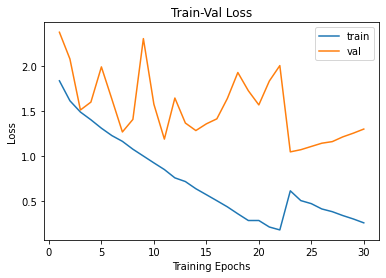

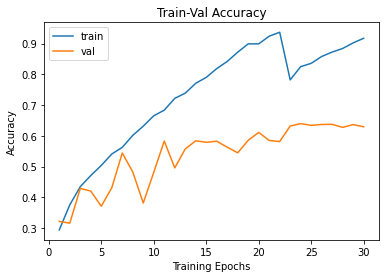

In [14]:
# epoch별 Loss 함수값과 정확도를 출력해보자
# Train-Validation progress
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()